In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd #data processing, CSV file I/O
import numpy as np #linear algebra
import seaborn as sns

In [ ]:
file_path = '/content/drive/My Drive/data_for_lstm.csv'

In [ ]:
data = pd.read_csv(file_path)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import math

In [ ]:
data.shape

(1194, 6)

In [ ]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))


In [ ]:
scaled_data.shape

(1194, 1)

In [ ]:
scaled_data

array([[0.23713378],
       [0.28518434],
       [0.2966119 ],
       ...,
       [0.9269168 ],
       [0.93505775],
       [0.97956276]])

In [ ]:
# Split data into train and test sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]
train_data.shape


(955, 1)

In [ ]:
# Function to create input features and target variable
def create_dataset(data, time_steps=1):
    X, Y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        Y.append(data[i + time_steps, 0])
    return np.array(X), np.array(Y)

In [ ]:
# Define time steps and create train/test datasets
time_steps = 30
X_train, Y_train = create_dataset(train_data, time_steps)
X_test, Y_test = create_dataset(test_data, time_steps)

In [ ]:
# Reshape input features for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=32, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))

In [ ]:
# Define the objective function for GWO
def objective_function(params):
    lr, decay = params
    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(X_train, Y_train, epochs=10, batch_size=16, verbose=1)
    mse = history.history['loss'][-1]
    return mse

In [ ]:
# Define the GWO algorithm
class GreyWolfOptimizer:
    def __init__(self, objective_function, lb, ub, dim, population_size, iterations):
        self.objective_function = objective_function
        self.lb = lb
        self.ub = ub
        self.dim = dim
        self.population_size = population_size
        self.iterations = iterations

    def initialize_population(self):
        return np.random.uniform(low=self.lb, high=self.ub, size=(self.population_size, self.dim))

    def search(self):
        alpha_pos = np.zeros(self.dim)
        alpha_score = float("inf")
        beta_pos = np.zeros(self.dim)
        beta_score = float("inf")
        delta_pos = np.zeros(self.dim)
        delta_score = float("inf")
        positions = self.initialize_population()
        convergence_curve = np.zeros(self.iterations)

        for iteration in range(self.iterations):
            for i in range(self.population_size):
                # Update alpha, beta, and delta positions
                if self.objective_function(positions[i]) < alpha_score:
                    delta_score = beta_score
                    delta_pos = beta_pos.copy()
                    beta_score = alpha_score
                    beta_pos = alpha_pos.copy()
                    alpha_score = self.objective_function(positions[i])
                    alpha_pos = positions[i].copy()
                elif self.objective_function(positions[i]) < beta_score:
                    delta_score = beta_score
                    delta_pos = beta_pos.copy()
                    beta_score = self.objective_function(positions[i])
                    beta_pos = positions[i].copy()
                elif self.objective_function(positions[i]) < delta_score:
                    delta_score = self.objective_function(positions[i])
                    delta_pos = positions[i].copy()

                # Update positions
                a = 2 - (iteration * (2 / self.iterations))
                r1 = np.random.random(self.dim)
                r2 = np.random.random(self.dim)
                A1 = 2 * a * r1 - a
                C1 = 2 * r2
                D_alpha = np.abs(C1 * alpha_pos - positions[i])
                X1 = alpha_pos - A1 * D_alpha

                r1 = np.random.random(self.dim)
                r2 = np.random.random(self.dim)
                A2 = 2 * a * r1 - a
                C2 = 2 * r2
                D_beta = np.abs(C2 * beta_pos - positions[i])
                X2 = beta_pos - A2 * D_beta

                r1 = np.random.random(self.dim)
                r2 = np.random.random(self.dim)
                A3 = 2 * a * r1 - a
                C3 = 2 * r2
                D_delta = np.abs(C3 * delta_pos - positions[i])
                X3 = delta_pos - A3 * D_delta

                positions[i] = (X1 + X2 + X3) / 3

            convergence_curve[iteration] = alpha_score

        return alpha_pos, alpha_score, convergence_curve


In [ ]:
lb = [0.0001, 0.0001]
ub = [0.1, 0.9]
dim = 2
population_size = 10
iterations = 12


Streaming output truncated to the last 5000 lines.
Epoch 10/10
58/58 [==============================] - 1s 12ms/step - loss: 5.5297e-04
Epoch 1/10
58/58 [==============================] - 3s 10ms/step - loss: 5.5834e-04
Epoch 2/10
58/58 [==============================] - 1s 10ms/step - loss: 5.4659e-04
Epoch 3/10
58/58 [==============================] - 1s 14ms/step - loss: 5.6121e-04
Epoch 4/10
58/58 [==============================] - 1s 16ms/step - loss: 5.5760e-04
Epoch 5/10
58/58 [==============================] - 1s 15ms/step - loss: 5.6246e-04
Epoch 6/10
58/58 [==============================] - 1s 14ms/step - loss: 5.6060e-04
Epoch 7/10
58/58 [==============================] - 1s 16ms/step - loss: 5.5455e-04
Epoch 8/10
58/58 [==============================] - 1s 12ms/step - loss: 5.5923e-04
Epoch 9/10
58/58 [==============================] - 1s 9ms/step - loss: 5.6493e-04
Epoch 10/10
58/58 [==============================] - 1s 10ms/step - loss: 5.6260e-04
Epoch 1/10
58/58 [======

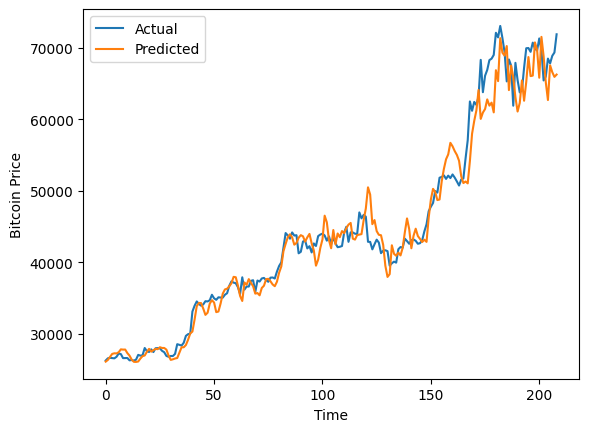

In [ ]:
# Create an instance of GreyWolfOptimizer and perform the search
gwo = GreyWolfOptimizer(objective_function, lb, ub, dim, population_size, iterations)
alpha_pos, alpha_score, convergence_curve = gwo.search()

# Compile the model with optimal parameters
lr_opt = alpha_pos[0]
decay_opt = alpha_pos[1]
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with optimal parameters
model.fit(X_train, Y_train, epochs=5, batch_size=16, verbose=2)

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Rescale the predictions
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
Y_train = scaler.inverse_transform([Y_train])
Y_test = scaler.inverse_transform([Y_test])

# Calculate evaluation metrics
train_rmse = math.sqrt(mean_squared_error(Y_train[0], train_predictions[:, 0]))
test_rmse = math.sqrt(mean_squared_error(Y_test[0], test_predictions[:, 0]))
train_mse = mean_squared_error(Y_train[0], train_predictions[:, 0])
test_mse = mean_squared_error(Y_test[0], test_predictions[:, 0])
train_mape = mean_absolute_percentage_error(Y_train[0], train_predictions[:, 0])
test_mape = mean_absolute_percentage_error(Y_test[0], test_predictions[:, 0])

# Print evaluation metrics
print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)
print('Train MSE:', train_mse)
print('Test MSE:', test_mse)
print('Train MAPE:', train_mape)
print('Test MAPE:', test_mape)

# Plot the predictions
plt.plot(Y_test[0], label='Actual')
plt.plot(test_predictions[:, 0], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.show()



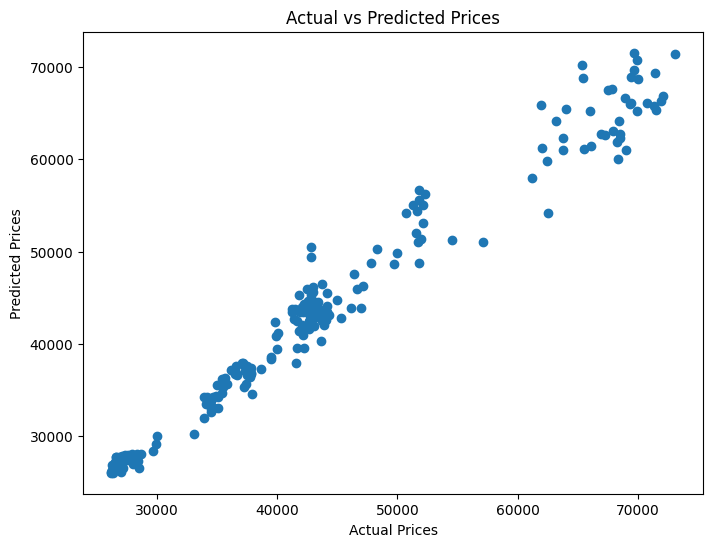

In [ ]:

plt.figure(figsize=(8, 6))
plt.scatter(Y_test[0], test_predictions[:, 0])
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.show()

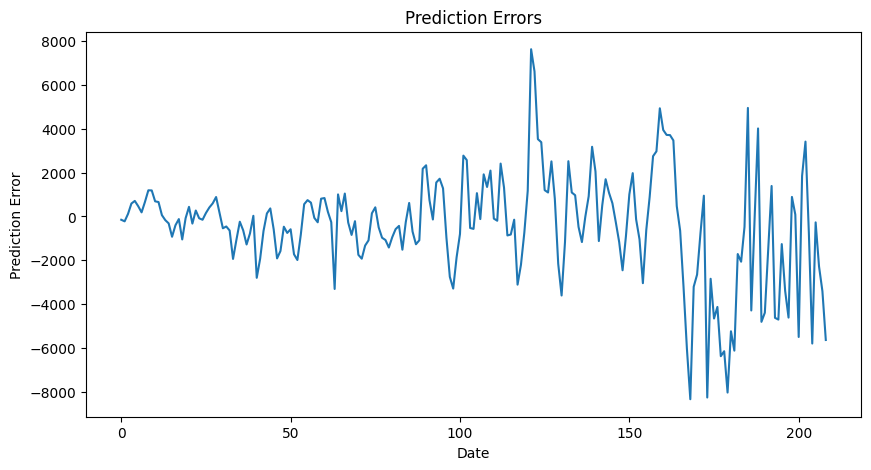

In [ ]:
# Error plot
errors = test_predictions[:, 0] - Y_test[0]
plt.figure(figsize=(10, 5))
plt.plot(errors)
plt.xlabel('Date')
plt.ylabel('Prediction Error')
plt.title('Prediction Errors')
plt.show()


In [ ]:
X_train.shape

(925, 30, 1)

In [ ]:
X_test.shape

(209, 30, 1)

In [ ]:
Y_train.shape

(925,)

In [ ]:
Y_test.shape

(28,)

In [ ]:
# Reshape input features for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=32, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))

In [ ]:
def objective_function(params):
    lr, decay = params
    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(X_train, Y_train, epochs=10, batch_size=16, verbose=1)
    mse = history.history['loss'][-1]
    return mse

In [ ]:
class GreyWolfOptimizer:
    def __init__(self, objective_function, lb, ub, dim, population_size, iterations):
        self.objective_function = objective_function
        self.lb = lb
        self.ub = ub
        self.dim = dim
        self.population_size = population_size
        self.iterations = iterations

    def initialize_population(self):
        return np.random.uniform(low=self.lb, high=self.ub, size=(self.population_size, self.dim))

    def search(self):
        alpha_pos = np.zeros(self.dim)
        alpha_score = float("inf")
        beta_pos = np.zeros(self.dim)
        beta_score = float("inf")
        delta_pos = np.zeros(self.dim)
        delta_score = float("inf")
        positions = self.initialize_population()
        convergence_curve = np.zeros(self.iterations)

        for iteration in range(self.iterations):
            for i in range(self.population_size):
                # Update alpha, beta, and delta positions
                if self.objective_function(positions[i]) < alpha_score:
                    delta_score = beta_score
                    delta_pos = beta_pos.copy()
                    beta_score = alpha_score
                    beta_pos = alpha_pos.copy()
                    alpha_score = self.objective_function(positions[i])
                    alpha_pos = positions[i].copy()
                elif self.objective_function(positions[i]) < beta_score:
                    delta_score = beta_score
                    delta_pos = beta_pos.copy()
                    beta_score = self.objective_function(positions[i])
                    beta_pos = positions[i].copy()
                elif self.objective_function(positions[i]) < delta_score:
                    delta_score = self.objective_function(positions[i])
                    delta_pos = positions[i].copy()

                # Update positions
                a = 2 - (iteration * (2 / self.iterations))
                r1 = np.random.random(self.dim)
                r2 = np.random.random(self.dim)
                A1 = 2 * a * r1 - a
                C1 = 2 * r2
                D_alpha = np.abs(C1 * alpha_pos - positions[i])
                X1 = alpha_pos - A1 * D_alpha

                r1 = np.random.random(self.dim)
                r2 = np.random.random(self.dim)
                A2 = 2 * a * r1 - a
                C2 = 2 * r2
                D_beta = np.abs(C2 * beta_pos - positions[i])
                X2 = beta_pos - A2 * D_beta

                r1 = np.random.random(self.dim)
                r2 = np.random.random(self.dim)
                A3 = 2 * a * r1 - a
                C3 = 2 * r2
                D_delta = np.abs(C3 * delta_pos - positions[i])
                X3 = delta_pos - A3 * D_delta

                positions[i] = (X1 + X2 + X3) / 3

            convergence_curve[iteration] = alpha_score

        return alpha_pos, alpha_score, convergence_curve




In [ ]:
# Define the bounds, dimension, population size, and number of iterations for GWO
lb = [0.0001, 0.0001]
ub = [0.1, 0.9]
dim = 2
population_size = 10
iterations = 12


In [ ]:
print("train_predictions shape:", train_predictions.shape)
print("test_predictions shape:", test_predictions.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

train_predictions shape: (156, 1)
test_predictions shape: (28, 1)
Y_train shape: (1, 156)
Y_test shape: (1, 28)
